In [175]:

import pprint
import random
from datetime import datetime, timedelta
import string
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
import numpy as np
import requests
from colorspacious import cspace_converter
from collections import OrderedDict

## Get covid 19 stats for Alabama

In [235]:
abbrevdf = pd.read_json('state_abbreviations.json')
states = abbrevdf['Code'].to_numpy()
print(states)

['AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'DC' 'FL' 'GA' 'HI' 'ID' 'IL'
 'IN' 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT' 'NE'
 'NV' 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD'
 'TN' 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY']


In [243]:
#states = ['AL','GA','FL','TN','LA','CA','NY','WA']
df = pd.DataFrame()
for state in states:
    url='https://api.covidtracking.com/v1/states/{s}/daily.json'.format(s = state.lower())
    response = requests.request("GET", url)
    statedf = pd.read_json(response.text)
    statedf['date'] = pd.to_datetime(statedf['date'], format='%Y%m%d')
    df = pd.concat([df,statedf])
#df.rename(columns={'state': 'Code'},inplace=True)
#print(df.head())
print(df.head())

date state  positive  negative  pending  hospitalizedCurrently  \
0 2020-08-24    AL    116710  806609.0      NaN                 1149.0   
1 2020-08-23    AL    115060  806609.0      NaN                 1093.0   
2 2020-08-22    AL    114532  801750.0      NaN                 1067.0   
3 2020-08-21    AL    112770  784330.0      NaN                 1168.0   
4 2020-08-20    AL    112449  784330.0      NaN                 1105.0   

   hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
0                 13793.0             NaN           1391.0   
1                 13502.0             NaN           1348.0   
2                 13502.0             NaN           1348.0   
3                 13330.0             NaN           1348.0   
4                 13330.0             NaN           1348.0   

   onVentilatorCurrently  ...  posNeg  deathIncrease hospitalizedIncrease  \
0                    NaN  ...  923319             11                  291   
1                    NaN  ...  92166

## Get population data for states

In [244]:
abbrevdf = pd.read_json('state_abbreviations.json')
popdf = pd.read_csv("scprc-est2019-18+pop-res.csv")
popdf.rename(columns={'NAME': 'State'}, inplace=True)
popdf = popdf.join(abbrevdf.set_index('State'), on='State')
#print(popdf.head())
population = popdf.loc[popdf['State'] == 'Alabama']['POPESTIMATE2019']
print(population)
df = df.join(popdf.set_index('Code'), on='state')
#df['POPESTIMATE2019'] = df['POPESTIMATE2019'].fillna(0)
df.head()

1    4903185
Name: POPESTIMATE2019, dtype: int64


,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,grade,SUMLEV,REGION,DIVISION,STATE,State,POPESTIMATE2019,POPEST18PLUS2019,PCNT_POPEST18PLUS,Abbrev
0,2020-08-24,AL,116710,806609.0,NaN,1149.0,13793.0,NaN,1391.0,NaN,...,,40,3,6,1,Alabama,4903185,3814879,77.8,Ala.
1,2020-08-23,AL,115060,806609.0,NaN,1093.0,13502.0,NaN,1348.0,NaN,...,,40,3,6,1,Alabama,4903185,3814879,77.8,Ala.
2,2020-08-22,AL,114532,801750.0,NaN,1067.0,13502.0,NaN,1348.0,NaN,...,,40,3,6,1,Alabama,4903185,3814879,77.8,Ala.
3,2020-08-21,AL,112770,784330.0,NaN,1168.0,13330.0,NaN,1348.0,NaN,...,,40,3,6,1,Alabama,4903185,3814879,77.8,Ala.
4,2020-08-20,AL,112449,784330.0,NaN,1105.0,13330.0,NaN,1348.0,NaN,...,,40,3,6,1,Alabama,4903185,3814879,77.8,Ala.


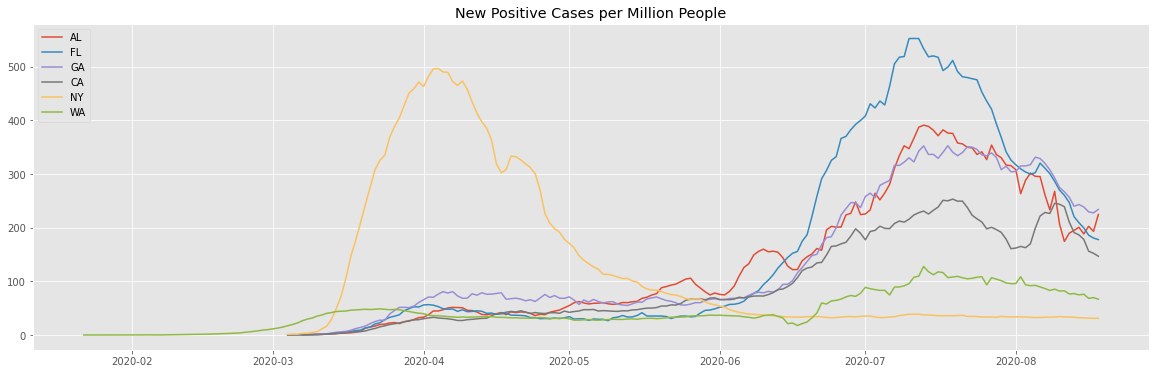

In [245]:
df['popPositiveIncrease'] = df['positiveIncrease'] / df['POPESTIMATE2019'] * 1000000
plt.style.use('ggplot')
plots = []
labels = []
plt.rcParams["figure.figsize"] = (20,6)
for state in ['AL','FL','GA','CA','NY','WA']:
    statedf = df[df['state'] == state]
    plot, = plt.plot(statedf['date'],statedf['popPositiveIncrease'].rolling(window=7).mean(),label=state)
    plots.append(plot)
    labels.append(state)
plt.legend(handles=plots, labels=labels,loc='upper left')
plt.title('New Positive Cases per Million People')
plt.show()